In [68]:
import matplotlib.pylab as plt
from matplotlib import gridspec

import numpy as np
import warnings,os
import re

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [69]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [70]:
import shutil

img_dir = "./dataset/ALL_IDB1/ALL_IDB1/im" 
healthy_dir = "./processed_data/healthy"
unHealthy_dir = "./processed_data/unHealthy"
# 1 -> unHealthy
# 0 -> healthy
if os.path.exists(healthy_dir):
    shutil.rmtree(healthy_dir)
if os.path.exists(unHealthy_dir):
    shutil.rmtree(unHealthy_dir)

os.makedirs("processed_data/healthy", exist_ok=True)
os.makedirs("processed_data/unHealthy", exist_ok=True)

def checkAndTransferFile ( filename ) :
    isUnHealthy =filename.__contains__("_1")
    if isUnHealthy :
        shutil.copyfile(img_dir + "/" + filename, unHealthy_dir + "/" + filename)
    else :
        shutil.copyfile(img_dir + "/" + filename, healthy_dir + "/" + filename)
    pass

images = os.listdir(img_dir)
for image in images:
    checkAndTransferFile(image)
    

In [71]:
def set_seed(seed=31416):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [72]:

# Set the image parameters
img_height = 224
img_width = 224
batch_size = 64
# Create the combined dataset
ds_train_ , ds_valid_ = tf.keras.utils.image_dataset_from_directory(
    "./processed_data",
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    subset="both",
    validation_split=0.2,
    class_names=["healthy", "unHealthy"]
)


Found 108 files belonging to 2 classes.
Using 87 files for training.
Using 21 files for validation.


In [73]:

#Data pipline
def convert_to_float(image,label):
    image=tf.image.convert_image_dtype(image,dtype="float")
    return image,label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train_.map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    )

ds_valid = (
    ds_valid_.map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    )


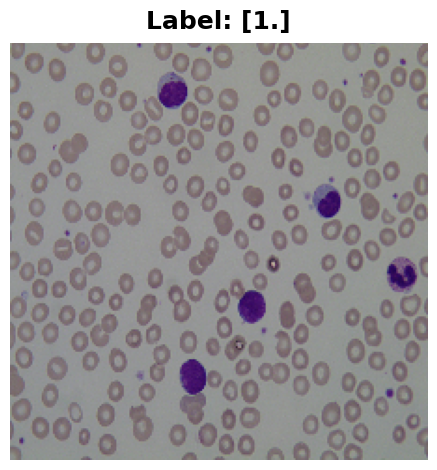

In [74]:

for images, labels in ds_valid.take(1):
    plt.imshow(images[2].numpy().astype("uint8"))
    plt.title(f"Label: {labels[1]}")
    plt.axis("off")
    plt.show()

In [75]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [77]:
vgg16 = VGG16(weights='imagenet',   #bard ->  Can be either 'imagenet' to load the pre-trained weights or None to train the model from scratch.
              include_top=False,    # bard ->  the top layer will be removed, and the model will be able to be used for feature extraction.
              input_shape=(224, 224, 3))

In [78]:
# Freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg16)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(epsilon=0.01),
              metrics=["binary_accuracy"],
               run_eagerly=True
              )


In [102]:
len(ds_train_)

2

In [80]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,

)

Epoch 1/10
2/2 [==============================] - 59s 16s/step - loss: 5.9598 - binary_accuracy: 0.4253 - val_loss: 2.0640 - val_binary_accuracy: 0.6190
Epoch 2/10
2/2 [==============================] - 56s 16s/step - loss: 2.2004 - binary_accuracy: 0.5747 - val_loss: 5.1155 - val_binary_accuracy: 0.3810
Epoch 3/10
2/2 [==============================] - 52s 16s/step - loss: 2.7472 - binary_accuracy: 0.6092 - val_loss: 0.1550 - val_binary_accuracy: 0.9524
Epoch 4/10
2/2 [==============================] - 51s 17s/step - loss: 0.1621 - binary_accuracy: 0.9425 - val_loss: 0.3016 - val_binary_accuracy: 0.8095
Epoch 5/10
2/2 [==============================] - 53s 16s/step - loss: 0.2423 - binary_accuracy: 0.8966 - val_loss: 0.0206 - val_binary_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 51s 16s/step - loss: 0.0084 - binary_accuracy: 1.0000 - val_loss: 0.1026 - val_binary_accuracy: 0.9524
Epoch 7/10
2/2 [==============================] - 50s 16s/step - loss: 0.0070 - bi

       loss  binary_accuracy  val_loss  val_binary_accuracy
0  5.959846         0.425287  2.064003             0.619048
1  2.200406         0.574713  5.115531             0.380952
2  2.747198         0.609195  0.154958             0.952381
3  0.162139         0.942529  0.301605             0.809524
4  0.242347         0.896552  0.020620             1.000000


<Axes: >

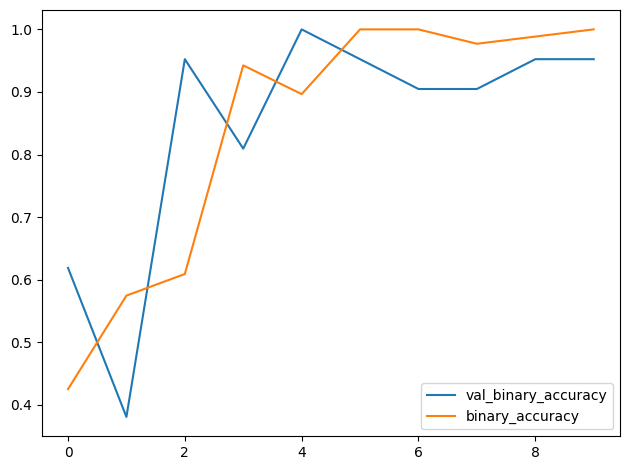

In [99]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
print(history_frame.head())
history_frame.loc[:, ['val_binary_accuracy', 'binary_accuracy']].plot()
# history_frame.loc[:, ['val_loss', 'loss']].plot()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(epsilon=0.01),
              metrics=["accuracy"],
               run_eagerly=True
              )
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,

)
